In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data65


In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/data')

In [ ]:
#加载飞桨和相关类库
import paddle
import paddle.nn as nn
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [ ]:
# 设置数据读取器，API自动读取MNIST数据训练集
train_dataset = paddle.vision.datasets.MNIST(mode='train')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


<Figure size 432x288 with 0 Axes>

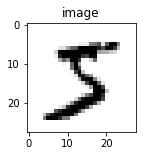

图像数据形状和对应数据为: (28, 28)
图像标签形状和对应数据为: (1,) [5]

打印第一个batch的第一个图像，对应标签数字为[5]


In [ ]:
train_data0 = np.array(train_dataset[0][0])
train_label_0 = np.array(train_dataset[0][1])

# 显示第一batch的第一个图像
plt.figure("Image") # 图像窗口名称
plt.figure(figsize=(2,2))
plt.imshow(train_data0, cmap=plt.cm.binary)
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

print("图像数据形状和对应数据为:", train_data0.shape)
print("图像标签形状和对应数据为:", train_label_0.shape, train_label_0)
print("\n打印第一个batch的第一个图像，对应标签数字为{}".format(train_label_0))

In [27]:
#搭建网络
class InceptionA(paddle.nn.Layer):
    def __init__(self,in_channels):
        super(InceptionA,self).__init__()
        self.conv11_1=nn.Conv2D(in_channels,16,1)
        self.conv33_1=nn.Conv2D(16,24,3,padding=1)
        self.conv333_1=nn.Conv2D(24,24,3,padding=1)
        
        self.conv11_2=nn.Conv2D(in_channels,16,1)
        self.conv55_2=nn.Conv2D(16,24,5,padding=2)
        
        self.conv11_3=nn.Conv2D(in_channels,16,1)
        
        self.conv11_4=nn.Conv2D(in_channels,24,1)
        self.pool_4=nn.AvgPool2D(kernel_size=3,stride=1,padding=1)
    def forward(self,x):
        x1=self.conv11_1(x)
        x1=self.conv33_1(x1)
        x1=self.conv333_1(x1)
        
        x2=self.conv11_2(x)
        x2=self.conv55_2(x2)
        
        x3=self.conv11_3(x)
        
        x4=self.pool_4(x)
        x4=self.conv11_4(x4)
        
        x=[x1,x2,x3,x4]
        return (paddle.concat(x,axis=1))
        
class MNIST(nn.Layer):
    def __init__(self):
        super(MNIST,self).__init__()
        self.conv1=nn.Conv2D(1,10,5)
        self.conv2=nn.Conv2D(88,20,5)
        self.pool=nn.MaxPool2D(2,2)
        
        self.incep1=InceptionA(in_channels=10)
        self.incep2=InceptionA(in_channels=20)
        
        self.fc1=nn.Linear(1408,512)
        self.fc2=nn.Linear(512,10)
        
    def forward(self,x):
        x=self.pool(self.conv1(x))
        x=F.relu(x)
        x=self.incep1(x)
        x=F.relu(self.pool(self.conv2(x)))
        x=self.incep2(x)
        x=paddle.fluid.layers.reshape(x,shape=[-1,1408])
        
        x=self.fc1(x)
        x=self.fc2(x)
        return x


In [28]:
# 声明网络结构
model = MNIST()

def train(model):
    # 启动训练模式
    model.train()
    # 加载训练集 batch_size 设为 16
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), 
                                        batch_size=16, 
                                        shuffle=True)
    # 定义优化器，使用随机梯度下降SGD优化器，学习率设置为0.001
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())

In [29]:
# 图像归一化函数，将数据范围为[0, 255]的图像归一化到[-1, 1]
def norm_img(img):
    # 验证传入数据格式是否正确，img的shape为[batch_size, 28, 28]
    assert len(img.shape) == 3
    batch_size, img_h, img_w = img.shape[0], img.shape[1], img.shape[2]
    # 归一化图像数据
    img = img/127.5 - 1
    # 将图像形式reshape为[batch_size, 784]
    img = paddle.reshape(img, [batch_size,1, img_h, img_w])
    
    return img

In [34]:
# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.set_image_backend('cv2')

def train(model):
    model.train()
    # 加载训练集 batch_size 设为 16
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 3
    Loss=[]
    for epoch in range(EPOCH_NUM):
        train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), batch_size=16,  shuffle=True)
        for batch_id, data in enumerate(train_loader):
            images = norm_img(data[0]).astype('float32')
            labels = data[1].astype('float32')
            images=paddle.to_tensor(images)
            labels=paddle.to_tensor(labels)
            #前向计算的过程
            predicts = model(images)
            #print()
            #y_pre=paddle.max(predicts,axis=1)
            #print(labels)
            #print(y_pre)
            
            # 计算损失
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            Loss.append(avg_loss)
            
            #每训练了1000批次的数据，打印下当前Loss的情况
            if batch_id % 1000 == 0:
                print("epoch_id: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
            
train(model)
paddle.save(model.state_dict(), './mnist.pdparams')

AssertionError: only one element variable can be converted to int.

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 